# KMeans Clustering with Normalizer

### Required Packages

In [65]:
!pip install plotly

In [66]:
import warnings
import operator
import itertools
import numpy as np 
import pandas as pd, seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
warnings.filterwarnings('ignore')
from collections import OrderedDict


### Initialization

Filepath of CSV file

In [67]:
file_path = ""

List of features which are required for model training

In [68]:
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [69]:
df=pd.read_csv('filename')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [70]:
X = df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.


In [71]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature and target set.

In [72]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
X.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


### Data Rescaling

Normalize samples individually to unit norm. For each sample (i.e. a row in the matrix) containing non-zero components, its norm (l1, l2 or inf) is rescaled independently of the others, so that it equals one. Besides dense NumPy arrays, these transformers are capable of working with scipy as well.

[normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

In [73]:

X_normalize=Normalizer().fit_transform(X)
X_normalize=pd.DataFrame(data = X_normalize,columns = X.columns)
X_normalize.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,0.413925,0.326783,0.849635
1,0.247025,0.176446,0.952809
2,0.760286,0.608229,0.228086
3,0.280697,0.195267,0.939723
4,0.580683,0.318439,0.749269


### Elbow Method
[Info](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

The Elbow Method is one of the most popular methods to determine this optimal value of k.
We iterate the values of k from 1 to 11 and calculate the distortion or inertia for each value of k in the given range. 
Where Inertia is the sum of squared distances of samples to their closest cluster center.
To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.

In [74]:
def ElbowPlot(X):
    SSE = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i,n_jobs=-1,random_state=123).fit(X)
        SSE.append(kmeans.inertia_)
    plt.plot(range(1, 11),SSE)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

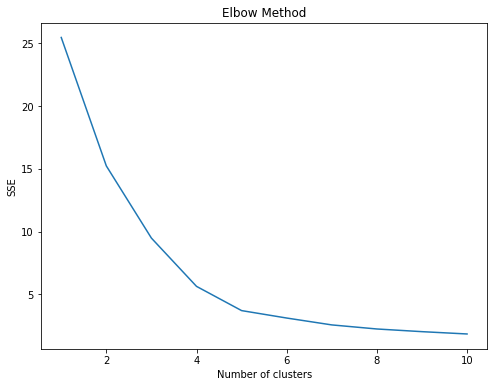

In [75]:
ElbowPlot(X_normalize)

Sometimes, the elbow method does not yield a clear decision (for example, if the elbow is not clear and sharp, or is ambiguous).  In such cases, alternatives such as the [silhouette coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) can be helpful.

### Silhouette Score 
[Reference](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
* Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.
* The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.



In [76]:
def SilhoutteScore(X):
    SScore=dict()
    for num_clusters in range(2,11):
        kmeans = KMeans(n_clusters=num_clusters,n_jobs=-1,random_state=123).fit(X)
        SScore[num_clusters]=silhouette_score(X, kmeans.labels_)
        SScore = OrderedDict( sorted(SScore.items(), key=operator.itemgetter(1),reverse=True))
    return SScore

In [77]:
SilhoutteScore(X_normalize)

OrderedDict([(5, 0.5435000932824923),
             (4, 0.5159774924113955),
             (6, 0.49291312470040455),
             (3, 0.46031634919166575),
             (7, 0.4567361578575364),
             (9, 0.43098404026566867),
             (8, 0.425503677630322),
             (10, 0.41326308284373703),
             (2, 0.3725111474217229)])

### Model

[Model API Reference](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

K-means is a centroid-based algorithm, or a distance-based algorithm.The k-means algorithm divides a set of  samples  into  disjoint clusters , each described by the mean of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from , although they live in the same space.

The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion.


#### Tuning Parameter

> **n_clusters** : The number of clusters to form as well as the number of centroids to generate. To find appropriate number of clusters utilize elbow method or silhouette score.

> **init** :  Method for initialization:
>    * ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
>    * ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.

> **n_init*: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

> **max_iter**: Maximum number of iterations of the k-means algorithm for a single run.

> **tol**: Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.

> **algorithm**: K-means algorithm to use. The classical EM-style algorithm is “full”. The “elkan” variation is more efficient on data with well-defined clusters, by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape (n_samples, n_clusters).

In [78]:
kmeans = KMeans(n_clusters=6,n_jobs=-1,random_state=123)
pred_y = kmeans.fit_predict(X_normalize)

### Cluster Analysis

First, we add the cluster labels from the trained model into the copy of the data frame for cluster analysis/visualization.

In [79]:
ClusterDF = X_normalize.copy(deep=True)
ClusterDF['ClusterID'] = pred_y
ClusterDF.head()

,Age,Annual Income (k$),Spending Score (1-100),ClusterID
0,0.413925,0.326783,0.849635,1
1,0.247025,0.176446,0.952809,1
2,0.760286,0.608229,0.228086,2
3,0.280697,0.195267,0.939723,1
4,0.580683,0.318439,0.749269,1


#### Cluster Records
The below bar graphs show the number of data points in each available cluster.

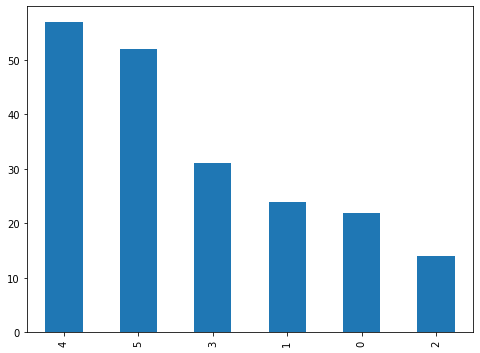

In [80]:
ClusterDF['ClusterID'].value_counts().plot(kind='bar')

#### Cluster Plots
Below written functions get utilized to plot 2-Dimensional and 3-Dimensional cluster plots. Plots include different available clusters along with cluster centroid.

In [81]:
def Plot2DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 2)):
        plt.rcParams["figure.figsize"] = (8,6)
        xi,yi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1])
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            plt.scatter(DFC[i[0]],DFC[i[1]],cmap=plt.cm.Accent,label=j)
        plt.scatter(kmeans.cluster_centers_[:,xi],kmeans.cluster_centers_[:,yi],marker="^",color="black",label="centroid")
        plt.xlabel(i[0])
        plt.ylabel(i[1])
        plt.legend()
        plt.show()

def Plot3DCluster(X_Cols,df):
    for i in list(itertools.combinations(X_Cols, 3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig,ax = plt.figure(figsize = (16, 10)),plt.axes(projection ="3d")
        ax.grid(b = True, color ='grey',linestyle ='-.',linewidth = 0.3,alpha = 0.2)
        for j in df['ClusterID'].unique():
            DFC=df[df.ClusterID==j]
            ax.scatter3D(DFC[i[0]],DFC[i[1]],DFC[i[2]],alpha = 0.8,cmap=plt.cm.Accent,label=j)
        ax.scatter3D(kmeans.cluster_centers_[:,xi],kmeans.cluster_centers_[:,yi],kmeans.cluster_centers_[:,zi],
                     marker="^",color="black",label="centroid")
        ax.set_xlabel(i[0])
        ax.set_ylabel(i[1])
        ax.set_zlabel(i[2])
        plt.legend()
        plt.show()
    
def Plotly3D(X_Cols,df):
    for i in list(itertools.combinations(X_Cols,3)):
        xi,yi,zi=df.columns.get_loc(i[0]),df.columns.get_loc(i[1]),df.columns.get_loc(i[2])
        fig1 = px.scatter_3d(kmeans.cluster_centers_,x=kmeans.cluster_centers_[:,xi],y=kmeans.cluster_centers_[:,yi],
                             z=kmeans.cluster_centers_[:,zi])
        fig2=px.scatter_3d(df, x=i[0], y=i[1],z=i[2],color=df['ClusterID'])
        fig3 = go.Figure(data=fig1.data + fig2.data,
                         layout=go.Layout(title=go.layout.Title(text="x:{}, y:{}, z:{}".format(i[0],i[1],i[2])))
                        )
        fig3.show()

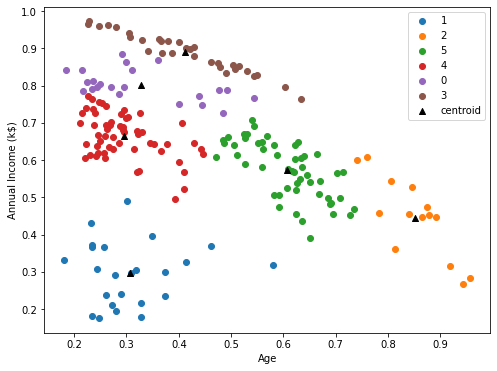

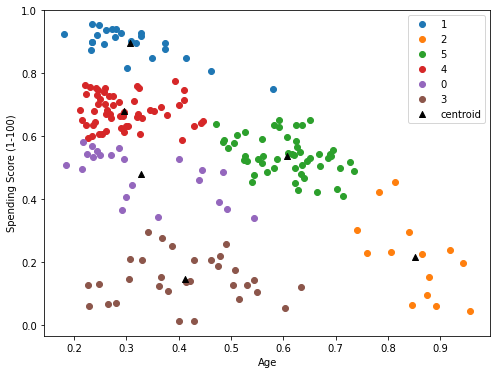

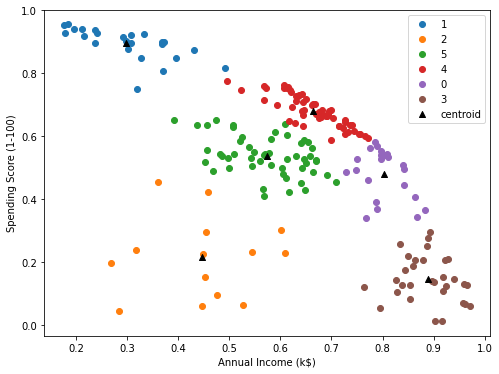

In [82]:
Plot2DCluster(X.columns,ClusterDF)

In [83]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams["lines.markeredgewidth"] = 1


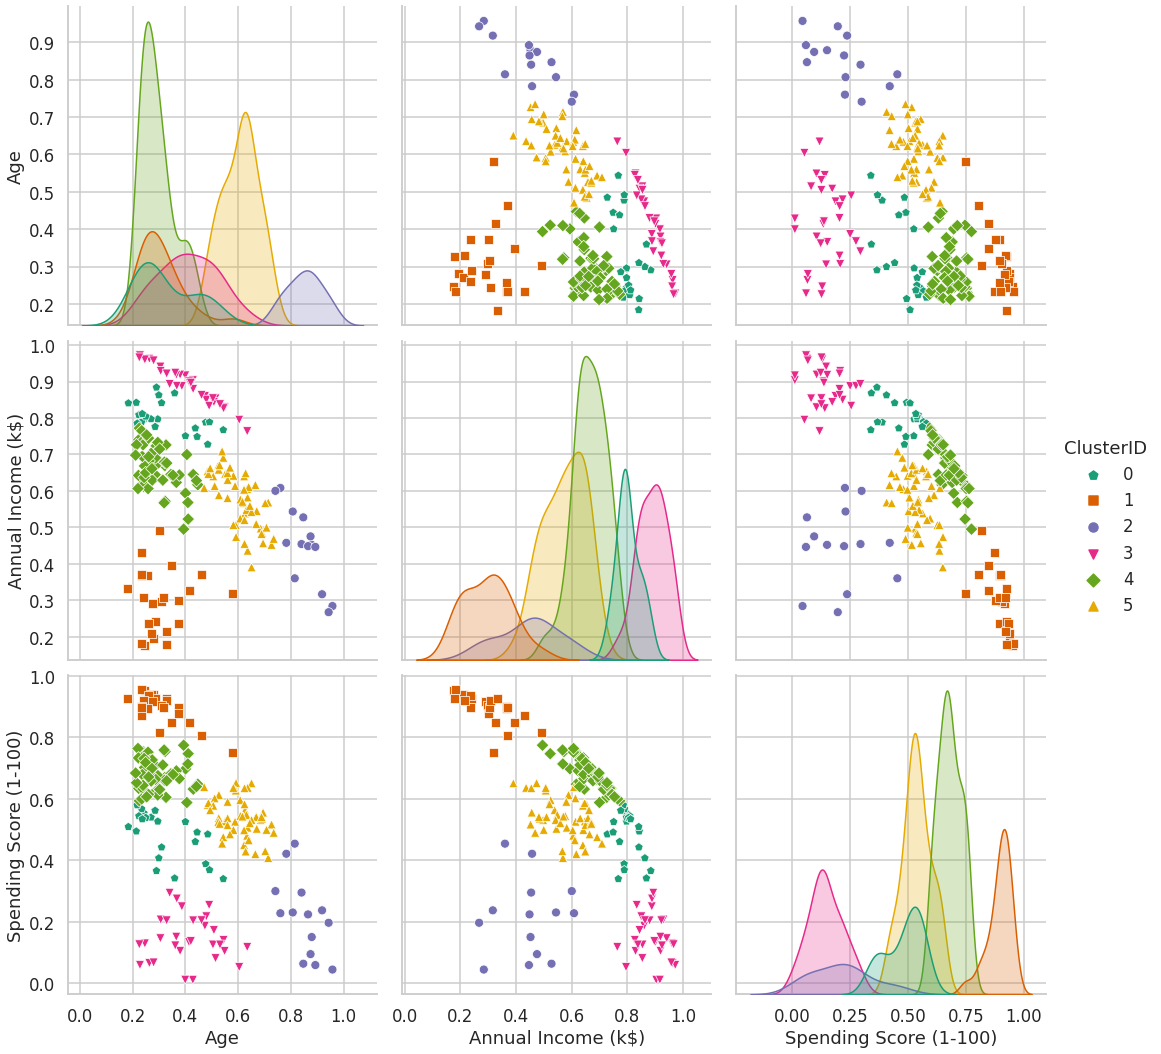

In [88]:
sns.pairplot(data=ClusterDF, hue='ClusterID', palette='Dark2', height=5)

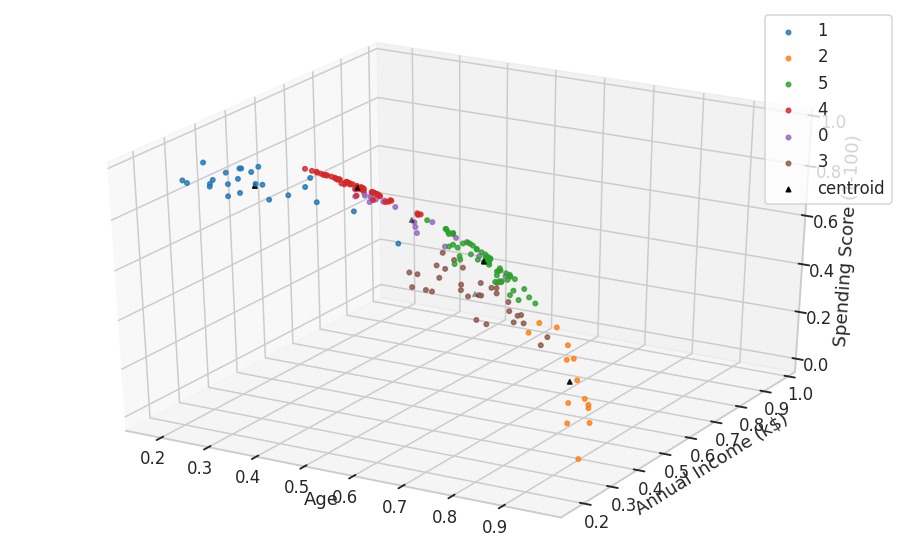

In [86]:
Plot3DCluster(X.columns,ClusterDF)

In [87]:
Plotly3D(X.columns,ClusterDF)